In [1]:
import os
import itertools
import shutil
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
"""
mobile = tf.keras.applications.mobilenet.MobileNet()

def prepare_image(file):
    img_path = 'dataset/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

from IPython.display import Image
Image(filename='data/MobileNet-samples/1.PNG', width=300,height=200)

preprocessed_image = prepare_image('1.PNG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
"""

In [4]:
"""
os.chdir('data')
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 5):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 159)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 160)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('..')
"""

In [2]:
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'
"""
train_batches = ImageDataGenerator(
                                  preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
                                  rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.15, 
                                  zoom_range=0.1, 
                                  channel_shift_range=10., 
                                  horizontal_flip=True
                                  ).flow_from_directory(
                                                       directory=train_path, 
                                                       target_size=(224,224),
                                                       batch_size=16
                                                      )
"""
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=32)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=32)
    
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=32, shuffle=False)

Found 6360 images belonging to 5 classes.
Found 795 images belonging to 5 classes.
Found 800 images belonging to 5 classes.


In [4]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()
print(len(mobile.layers))

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [5]:
x = mobile.layers[-6].output
#x = Dropout(0.5)(x)
output = Dense(units=5, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=output)

for layer in model.layers[:-23]:
    layer.trainable = False
    
model.summary() 
print(len(model.layers))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [5]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=17,
            verbose=2
)

model.save('models/model.h5')

Epoch 1/17
199/199 - 362s - loss: 0.1978 - accuracy: 0.9360 - val_loss: 0.0950 - val_accuracy: 0.9660
Epoch 2/17
199/199 - 356s - loss: 0.0283 - accuracy: 0.9936 - val_loss: 0.0277 - val_accuracy: 0.9912
Epoch 3/17
199/199 - 376s - loss: 0.0128 - accuracy: 0.9987 - val_loss: 0.0196 - val_accuracy: 0.9950
Epoch 4/17
199/199 - 414s - loss: 0.0075 - accuracy: 0.9991 - val_loss: 0.0151 - val_accuracy: 0.9975
Epoch 5/17
199/199 - 430s - loss: 0.0043 - accuracy: 0.9998 - val_loss: 0.0132 - val_accuracy: 0.9975
Epoch 6/17
199/199 - 425s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0109 - val_accuracy: 0.9962
Epoch 7/17
199/199 - 393s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 0.9962
Epoch 8/17
199/199 - 360s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0125 - val_accuracy: 0.9962
Epoch 9/17
199/199 - 382s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0125 - val_accuracy: 0.9950
Epoch 10/17
199/199 - 362s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0119 - 

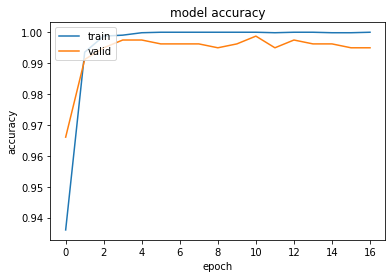

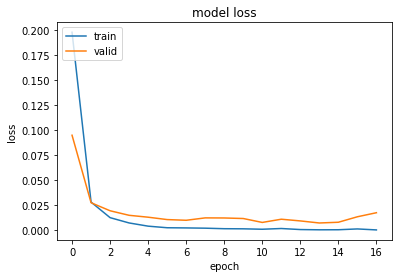

In [6]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [7]:
#model = load_model('models/model.h5')

test_labels = test_batches.classes
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [8]:
y_pred_bool = np.argmax(predictions, axis=1)

print(classification_report(test_labels, y_pred_bool))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       160
           1       1.00      1.00      1.00       160
           2       0.99      1.00      1.00       160
           3       1.00      0.99      0.99       160
           4       1.00      0.98      0.99       160

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[160   0   0   0   0]
 [  0 160   0   0   0]
 [  0   0 160   0   0]
 [  1   0   1 158   0]
 [  3   0   0   0 157]]


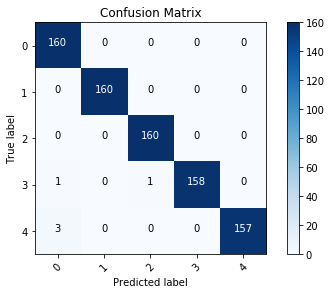

In [10]:
test_batches.class_indices

cm_plot_labels = ['0','1','2','3','4']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')